## Data preprocessing

In [680]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [741]:
#initialize dataframes from csv files
df_flights = pd.read_csv('flights.csv', nrows = 10000).drop('Unnamed: 0', axis=1)
df_fuel = pd.read_csv('fuel_consumption.csv').drop('Unnamed: 0', axis=1)
df_test = pd.read_csv('flights_test.csv', nrows = 10000).drop('Unnamed: 0', axis=1)
df_passengers = pd.read_csv('passengers_aggregated.csv').drop('Unnamed: 0', axis=1)
df_pass_all = pd.read_csv('passenger_subset.csv').drop('Unnamed: 0', axis=1)

In [742]:
# Dropping rows where target variable is null
df_flights.arr_delay.isnull().sum()
df_flights = df_flights[df_flights['arr_delay'].notna()]
df_flights.arr_delay.isnull().sum()

0

In [743]:
# Initialize datetime columns
df_flights['date'] = pd.to_datetime(df_flights['fl_date'])
df_flights['crs_dep_time'] = df_flights['crs_dep_time']/100
df_flights['crs_dep_time'] = df_flights['crs_dep_time'].astype(str)
df_flights[["hours", "minutes"]] = df_flights["crs_dep_time"].str.split(".", expand = True)
df_flights['hours'] = df_flights['hours'].astype(int)
df_flights['minutes'] = df_flights['minutes'].astype(int)
df_flights['crs_dep_time'] = df_flights['crs_dep_time'].astype(float)

In [744]:
# Add a month column for analysis
df_flights['month'] = pd.DatetimeIndex(df_flights['fl_date']).month

In [745]:
# Aggregate hour values into seperate time slots
conditions = [
    (df_flights['hours'] >= 0) & (df_flights['hours'] <= 6),
    (df_flights['hours'] <= 12),
    (df_flights['hours'] > 12) & (df_flights['hours'] <= 18),
    (df_flights['hours'] > 18) & (df_flights['hours'] <= 24)
    ]

# initialize list of values for each condition
values = [1,2,3,4]

# Create a column for the time slots
df_flights['time_slot'] = np.select(conditions, values)

In [746]:

# Group distance travelled by flights into short, medium and long

conditions = [
    (df_flights['distance'] <= 1000),
    (df_flights['distance'] > 1000) & (df_flights['distance'] <= 2000),
    (df_flights['distance'] > 2000)
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
df_flights['haul_duration'] = np.select(conditions, values)


In [747]:
# splitting the city and state for analysis
df_flights[['org_city','org_state']] = df_flights.origin_city_name.str.split(",", expand = True)
df_flights[['dest_city','dest_state']] = df_flights.dest_city_name.str.split(",", expand = True)

[[Text(0, 0, 'security'),
  Text(1, 0, 'weather'),
  Text(2, 0, 'carrier'),
  Text(3, 0, 'nas'),
  Text(4, 0, 'late_aircraft')]]

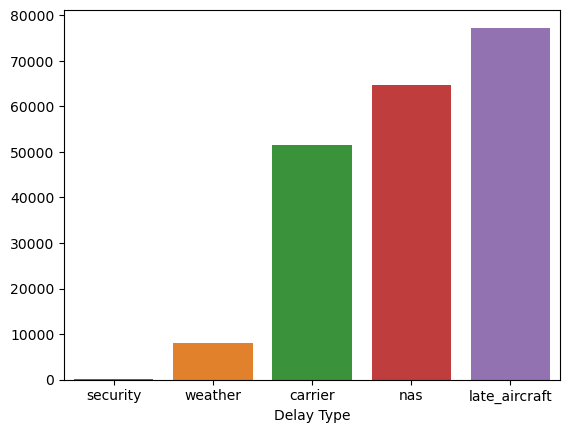

In [748]:
# Finding out what types of delays are most common
df_delay_type = df_flights[['carrier_delay','weather_delay','nas_delay', 'security_delay', 'late_aircraft_delay']]
ax = sns.barplot(data=df_delay_type.sum(), x = df_delay_type.sum().index, y = df_delay_type.sum().values)
ax.set(xlabel = "Delay Type")
ax.set(xticklabels=['security','weather','carrier','nas','late_aircraft'])

#### Initializing the training and test sets before we do feature engineering on the training set

In [749]:
# Before we begin with modelling we need to drop columns we didnt use for analysis or redundant columns
df_flights.drop(['fl_date','mkt_unique_carrier','branded_code_share','mkt_carrier','mkt_carrier_fl_num','tail_num','origin','origin_city_name','dest','dest_city_name', 'dep_time','taxi_out', 'wheels_off', 'wheels_on', 'taxi_in','arr_time','cancelled', 'cancellation_code', 'diverted',
       'dup','actual_elapsed_time', 'air_time', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'first_dep_time',
       'total_add_gtime', 'longest_add_gtime', 'no_name','date', 'minutes', 'month'], axis =1, inplace=True)

In [750]:
df_flights.columns

Index(['op_unique_carrier', 'op_carrier_fl_num', 'origin_airport_id',
       'dest_airport_id', 'crs_dep_time', 'dep_delay', 'crs_arr_time',
       'arr_delay', 'crs_elapsed_time', 'flights', 'distance', 'hours',
       'time_slot', 'haul_duration', 'org_city', 'org_state', 'dest_city',
       'dest_state'],
      dtype='object')

In [691]:
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder()

df_flights['op_unique_carrier'] = labels.fit_transform(df_flights[['op_unique_carrier']])
df_flights['op_carrier_fl_num'] = labels.fit_transform(df_flights[['op_carrier_fl_num']])
df_flights['origin_airport_id'] = labels.fit_transform(df_flights[['origin_airport_id']])
df_flights['dest_airport_id'] = labels.fit_transform(df_flights[['dest_airport_id']])
df_flights['org_city'] = labels.fit_transform(df_flights[['org_city']])
df_flights['org_state'] = labels.fit_transform(df_flights[['org_state']])
df_flights['dest_city'] = labels.fit_transform(df_flights[['dest_city']])
df_flights['dest_state'] = labels.fit_transform(df_flights[['dest_state']])                                                   


/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was 

In [692]:
df_flights

,op_unique_carrier,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_delay,crs_arr_time,arr_delay,crs_elapsed_time,flights,distance,hours,time_slot,haul_duration,org_city,org_state,dest_city,dest_state
0,2,2323,39,9,7.00,-6.0,845,-9.0,105.0,1.0,554.0,7,2,1,40,34,11,9
1,2,2324,9,38,14.59,-1.0,1620,-18.0,81.0,1.0,226.0,14,3,1,11,9,33,26
2,2,2331,106,146,20.15,0.0,2240,25.0,145.0,1.0,834.0,20,4,1,105,4,144,36
3,2,2332,128,9,8.25,-3.0,1128,-12.0,123.0,1.0,669.0,8,2,1,116,49,11,9
4,2,2334,9,53,9.29,-1.0,1036,1.0,127.0,1.0,743.0,9,2,1,11,9,49,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,4066,144,103,11.55,85.0,1300,69.0,65.0,1.0,197.0,11,2,1,137,4,96,32
9996,8,2470,144,120,6.35,6.0,1230,-19.0,235.0,1.0,1706.0,6,1,2,137,4,37,13
9997,8,1591,144,138,18.25,23.0,1945,34.0,80.0,1.0,362.0,18,3,1,137,4,132,4
9998,8,2272,144,138,19.55,33.0,2110,62.0,75.0,1.0,362.0,19,4,1,137,4,132,4


In [751]:
from sklearn.model_selection import train_test_split
y = df_flights[['arr_delay']]
X_train, X_test, y_train, y_test = train_test_split(df_flights, y, test_size=0.4, random_state=42, shuffle = True)

## Feature Engineering

##### Majority of the delays are caused by late aircraft, so we will engineer features relating to that

In [752]:
# avg departure delay per carrier per airport
df_carr_delay = X_train[['dep_delay','op_unique_carrier','origin_airport_id']].groupby(['origin_airport_id','op_unique_carrier']).mean().round(1)
df_carr_delay.rename(columns={'dep_delay':'delay_carrier'},inplace=True)

In [753]:
# avg departure delay per flight
df_flight_delay = X_train[['op_carrier_fl_num', 'dep_delay']].groupby('op_carrier_fl_num').mean().round(1)
df_flight_delay.rename(columns = {'dep_delay':'delay_flights'}, inplace=True)


In [754]:
# avg departure delay per flight per airport
df_flight_airport_delay = X_train[['op_carrier_fl_num', 'origin_airport_id','dep_delay']].groupby(['origin_airport_id','op_carrier_fl_num']).mean().round(1)
df_flight_airport_delay.rename(columns = {'dep_delay':'delay_flights_airport'}, inplace=True)

In [755]:
# average departure delay for airport accoridng to time of day
df_flights_airport_delay_time = X_train[['origin_airport_id', 'time_slot', 'dep_delay']].groupby(['origin_airport_id', 'time_slot']).mean().round(1)
df_flights_airport_delay_time.rename(columns = {'dep_delay':'delay_airport'}, inplace=True)
df_flights_airport_delay_time

delay_airport
origin_airport_id time_slot               
10135             1                   -1.0
10136             3                   26.0
10140             1                   -3.0
                  2                    2.9
                  3                   11.5
...                                    ...
15624             3                    3.4
                  4                   -7.7
15919             1                   -6.0
                  2                   -4.7
                  3                   -3.8

[555 rows x 1 columns]

In [756]:
# average departure delay for haul duration
df_flights_type_delay = X_train[['haul_duration','op_carrier_fl_num','dep_delay']].groupby(['haul_duration','op_carrier_fl_num']).mean().round(1)
df_flights_type_delay.rename(columns = {'dep_delay':'flight_type_delay'}, inplace=True)

In [757]:
# average departure delay per state per flight
df_state_delay = X_train[['org_state','op_carrier_fl_num','dep_delay']].groupby(['org_state','op_carrier_fl_num']).mean().round(1)
df_state_delay.rename(columns={'dep_delay':'state_delay'}, inplace=True)

In [758]:
# average dest airport departure delay per hour of day
df_delay_hour = X_train[['dest_airport_id','hours','dep_delay']].groupby(['dest_airport_id','hours']).mean()
df_delay_hour.rename(columns={'dep_delay':'delay_hour'}, inplace=True)

In [759]:
# Air traffic at the destination airport per time of day
df_dest_air_traffic = X_train[['dest_airport_id','time_slot','flights']].groupby(['dest_airport_id','time_slot']).sum()
df_dest_air_traffic.rename(columns = {'flights':'aiport_traffic_dest'}, inplace=True)

In [760]:
# Air traffic at the origin airport per time of day
df_org_air_traffic = X_train[['origin_airport_id','time_slot','flights']].groupby(['origin_airport_id','time_slot']).sum()
df_org_air_traffic.rename(columns = {'flights':'aiport_traffic_origin'}, inplace=True)

In [761]:
# Passengers and payload in origin airport
#df_passenger = pd.read_csv('pass_sample.csv')
#df_pass_org = df_passenger[['passengers','payload', 'origin_airport_id']].groupby('origin_airport_id').mean().round(1)
#df_pass_org_add = pd.merge(X_train, df_pass_org, on='origin_airport_id', how='inner')
#df_pass_org_air = df_pass_org_add[['origin_airport_id','passengers','payload']].groupby(['origin_airport_id']).mean().round(1)
#df_pass_org_air.rename(columns = {'passengers':'passengers_org', 'payload':'payload_org'},inplace=True)

In [762]:
# Passengers and payload in destination airport
#df_pass_dest = df_passenger[['passengers','payload', 'dest_airport_id']].groupby('dest_airport_id').mean().round(1)
#df_pass_dest_add = pd.merge(X_train, df_pass_dest, on='dest_airport_id', how='inner')
#df_pass_dest_air = df_pass_dest_add[['dest_airport_id','passengers','payload']].groupby(['dest_airport_id']).mean().round(1)
#df_pass_dest_air.rename(columns = {'passengers':'passengers_dest', 'payload':'payload_dest'}, inplace=True)

##### Note that we couldn't find any common airline_id to merge the passengers/fuel consumption table and the flights table, the only possible options were airport for passengers and unique carriers for fuel consumption. However in our X_train dataset there were only 7 unique carriers so we would barely get any variance in that feature if we did do a merge.

## Modelling

In [763]:
# Define a function that takes a dataframe and merges all our features onto it
def get_features(df):
    df = df.merge(df_carr_delay, on=['origin_airport_id','op_unique_carrier'], how='inner')
    df = df.merge(df_flight_delay, on='op_carrier_fl_num', how='inner')
    df = df.merge(df_flight_airport_delay, on=['origin_airport_id','op_carrier_fl_num'], how='inner')
    df = df.merge(df_flights_airport_delay_time, on=['origin_airport_id', 'time_slot'], how='inner')
    df = df.merge(df_flights_type_delay, on=['haul_duration','op_carrier_fl_num'], how='inner')
    df = df.merge(df_state_delay, on=['org_state','op_carrier_fl_num'], how='inner') 
    df = df.merge(df_delay_hour, on=['dest_airport_id','hours'], how='inner') 
    df = df.merge(df_dest_air_traffic, on=['dest_airport_id','time_slot'], how='inner') 
    df = df.merge(df_org_air_traffic, on=['origin_airport_id','time_slot'], how='inner') 
    #df = df.merge(df_pass_org_air, on='origin_airport_id', how='inner') 
    #df = df.merge(df_pass_dest_air, on='dest_airport_id', how='inner') 
    return df


In [706]:
X_train_upd=get_features(X_train)
X_test_upd = get_features(X_test)

In [707]:
# Initialize the y_train and y_test and drop them from the training dataset
Y_train = X_train_upd[['arr_delay']]
Y_test = X_test_upd[['arr_delay']]
X_train_upd.drop('arr_delay',axis=1, inplace=True)
X_test_upd.drop('arr_delay',axis=1, inplace=True)

In [708]:
# We need to turn object datatypes into numeric ones for analysis
X_test_upd.dtypes

op_unique_carrier          int64
op_carrier_fl_num          int64
origin_airport_id          int64
dest_airport_id            int64
crs_dep_time             float64
dep_delay                float64
crs_arr_time               int64
crs_elapsed_time         float64
flights                  float64
distance                 float64
hours                      int64
time_slot                  int64
haul_duration              int64
org_city                   int64
org_state                  int64
dest_city                  int64
dest_state                 int64
delay_carrier            float64
delay_flights            float64
delay_flights_airport    float64
delay_airport            float64
flight_type_delay        float64
state_delay              float64
delay_hour               float64
aiport_traffic_dest      float64
aiport_traffic_origin    float64
dtype: object

In [709]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [710]:
X_train_upd.drop(['dep_delay','flights'], axis=1, inplace=True)

In [711]:
X_test_upd.drop(['dep_delay','flights'], axis=1, inplace=True)

In [712]:
# Standard scale fit the training set and transform the testing set
scaler = StandardScaler()
scaler.fit(X_train_upd)
X_train_scaled = scaler.transform(X_train_upd)
X_test_scaled = scaler.transform(X_test_upd)

In [713]:
reg = LinearRegression()

In [714]:
# Linear regression on the X_train and X_test split
reg.fit(X_train_scaled, Y_train)
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

r2_train = r2_score(Y_train, y_train_pred)
r2_test = r2_score(Y_test, y_test_pred)


print(f'Train R^2:\t{r2_train}\nTest R^2:\t{r2_test}')

Train R^2:	0.932107294887292
Test R^2:	-0.7604442945206376


In [715]:
# Cross validation on the training set
k_folds = 5
cv_r2 = cross_val_score(reg, X_train_scaled, Y_train, cv=k_folds, scoring='r2')
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.9238362715665611
Std.:	0.022116821821504703


#### Our data seems to be over fitting, we will now introduce some hypoparameter through gridsearch cv to offset this

In [716]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
# Make a dictionary with model arguments as keys and lists of grid settings as values
param_grid = {
    'alpha': [0.01, 0.001, 0.01, 1],
    'l1_ratio': [0.85,0.9,0.95,0.1]
}

grid = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, cv=k_folds, scoring='r2', verbose=1, n_jobs=-1) # verbose=1 -> print results, n_jobs=-1 -> use all processors in parallel
grid_result = grid.fit(X_train_scaled, Y_train)

best_r2 = grid_result.best_score_
best_alpha = grid_result.best_params_['alpha']
best_l1_ratio = grid_result.best_params_['l1_ratio']
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2}\nAlpha:\t{best_alpha}\nL1 ratio:\t{best_l1_ratio}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.978e+05, tolerance: 1.517e+03
  model = cd_fast.enet_coordinate_descent(
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.666e+05, tolerance: 1.810e+03
  model = cd_fast.enet_coordinate_descent(
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

The best hyperparameter settings achieve a cross-validated R^2 of: 0.9238581316081491
Alpha:	0.01
L1 ratio:	0.95


In [717]:
# Using the best hyperparameters, retrain on the entire train set and evaluate on the test set
best_model = grid_result.best_estimator_    # Sklearn automatically retrains the model on the whole training set following cross-validation using the best hyperparameters
y_pred = best_model.predict(X_test_scaled)
r2_test = r2_score(Y_test, y_pred)
print(f'R^2 on the test set:\t{r2_test}')

R^2 on the test set:	-0.7578055442029021


#### Try Random Forest


In [729]:
model = RandomForestRegressor()
model.fit(X_train_upd,Y_train)
predictions_test = model.predict(X_test_upd)

/var/folders/sy/61n20bpj6f9dzqcywtfdt3z00000gn/T/ipykernel_6340/3865825749.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_upd,Y_train)


In [730]:
print(model.score(X_test_upd,Y_test))

-0.8663331699638996


In [731]:
model = RandomForestRegressor()
model.fit(X_train_upd,Y_train)
predictions_train = model.predict(X_train_upd)

/var/folders/sy/61n20bpj6f9dzqcywtfdt3z00000gn/T/ipykernel_6340/1917626742.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_upd,Y_train)


In [732]:
print(model.score(X_train_upd,Y_train))

0.9898632873500258


#### Because the ElasticNet gave us the smallest R^2 values, we will use that on the final model.

In [737]:
def redo_features(df_flights):
    df_flights['date'] = pd.to_datetime(df_flights['fl_date'])
    df_flights['crs_dep_time'] = df_flights['crs_dep_time']/100
    df_flights['crs_dep_time'] = df_flights['crs_dep_time'].astype(str)
    df_flights[["hours", "minutes"]] = df_flights["crs_dep_time"].str.split(".", expand = True)
    df_flights['hours'] = df_flights['hours'].astype(int)
    df_flights['minutes'] = df_flights['minutes'].astype(int)
    df_flights['crs_dep_time'] = df_flights['crs_dep_time'].astype(float)
    return df_flights

In [739]:
df_test1 = redo_features(df_test)

In [765]:
df_test1['month'] = pd.DatetimeIndex(df_test1['fl_date']).month

In [767]:
def get_time_slots(df_flights):
    # Aggregate hour values into seperate time slots
    conditions = [
    (df_flights['hours'] >= 0) & (df_flights['hours'] <= 6),
    (df_flights['hours'] <= 12),
    (df_flights['hours'] > 12) & (df_flights['hours'] <= 18),
    (df_flights['hours'] > 18) & (df_flights['hours'] <= 24)
    ]

# initialize list of values for each condition
    values = [1,2,3,4]

# Create a column for the time slots
    df_flights['time_slot'] = np.select(conditions, values)
    return df_flights
    

In [769]:
df_test2 = get_time_slots(df_test1)

In [770]:
def group_dist(df_flights):
# Group distance travelled by flights into short, medium and long

    conditions = [
    (df_flights['distance'] <= 1000),
    (df_flights['distance'] > 1000) & (df_flights['distance'] <= 2000),
    (df_flights['distance'] > 2000)
    ]

# create a list of the values we want to assign for each condition
    values = [1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
    df_flights['haul_duration'] = np.select(conditions, values)
    return df_flights

In [773]:
df_test3 = group_dist(df_test2)

In [772]:
def split_loc(df_flights):
    # splitting the city and state for analysis
    df_flights[['org_city','org_state']] = df_flights.origin_city_name.str.split(",", expand = True)
    df_flights[['dest_city','dest_state']] = df_flights.dest_city_name.str.split(",", expand = True)
    return df_flights

In [775]:
df_test4 = split_loc(df_test3)

In [777]:
df_test5 = get_features(df_test4)

In [783]:
df_test6 = df_test5.loc[:,X_train_upd.columns]

In [787]:
df_test6

,op_unique_carrier,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,hours,time_slot,...,dest_state,delay_carrier,delay_flights,delay_flights_airport,delay_airport,flight_type_delay,state_delay,delay_hour,aiport_traffic_dest,aiport_traffic_origin
0,DL,354,13487,11057,0.2020,2356,156,930,0,1,...,NC,29.7,70.0,70.0,14.3,70.0,70.0,20.333333,22.0,13.0
1,AA,1395,13487,11298,0.0631,932,181,852,0,1,...,TX,3.7,5.0,5.0,14.3,5.0,5.0,18.000000,51.0,13.0
2,DL,1889,13487,11298,0.1945,2225,160,852,0,1,...,TX,29.7,-2.0,-2.0,14.3,-2.0,-2.0,18.000000,51.0,13.0
3,NK,614,13487,10821,0.1710,2043,153,936,0,1,...,MD,-1.7,0.0,0.0,14.3,0.0,0.0,6.000000,16.0,13.0
4,DL,1188,13487,10397,0.1310,1642,152,907,0,1,...,GA,29.7,18.0,18.0,14.3,18.0,18.0,-5.000000,98.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,DL,1638,12191,10397,0.1005,1305,120,696,0,1,...,GA,-2.0,-1.0,-1.0,0.6,-1.0,-0.5,-5.000000,98.0,9.0
444,DL,1693,12191,10397,0.0600,901,121,696,0,1,...,GA,-2.0,-1.0,-1.0,0.6,-1.0,-1.0,-5.000000,98.0,9.0
445,DL,1738,13360,10397,0.0555,732,97,442,0,1,...,GA,-8.3,-8.0,-8.0,-8.0,-8.0,-8.0,-5.000000,98.0,1.0
446,DL,1665,11641,10397,0.0600,733,93,331,0,1,...,GA,0.0,1.0,1.0,1.0,1.0,1.0,-5.000000,98.0,1.0


In [792]:
def get_labels(df_flights):
    labels = LabelEncoder()

    df_flights['op_unique_carrier'] = labels.fit_transform(df_flights[['op_unique_carrier']])
    df_flights['op_carrier_fl_num'] = labels.fit_transform(df_flights[['op_carrier_fl_num']])
    df_flights['origin_airport_id'] = labels.fit_transform(df_flights[['origin_airport_id']])
    df_flights['dest_airport_id'] = labels.fit_transform(df_flights[['dest_airport_id']])
    df_flights['org_city'] = labels.fit_transform(df_flights[['org_city']])
    df_flights['org_state'] = labels.fit_transform(df_flights[['org_state']])
    df_flights['dest_city'] = labels.fit_transform(df_flights[['dest_city']])
    df_flights['dest_state'] = labels.fit_transform(df_flights[['dest_state']])
    return df_flights

In [794]:
df_test7 = get_labels(df_test6)

/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was 

In [795]:
df_test7

,op_unique_carrier,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,hours,time_slot,...,dest_state,delay_carrier,delay_flights,delay_flights_airport,delay_airport,flight_type_delay,state_delay,delay_hour,aiport_traffic_dest,aiport_traffic_origin
0,1,43,55,3,0.2020,2356,156,930,0,1,...,6,29.7,70.0,70.0,14.3,70.0,70.0,20.333333,22.0,13.0
1,0,219,55,5,0.0631,932,181,852,0,1,...,9,3.7,5.0,5.0,14.3,5.0,5.0,18.000000,51.0,13.0
2,1,306,55,5,0.1945,2225,160,852,0,1,...,9,29.7,-2.0,-2.0,14.3,-2.0,-2.0,18.000000,51.0,13.0
3,3,60,55,2,0.1710,2043,153,936,0,1,...,4,-1.7,0.0,0.0,14.3,0.0,0.0,6.000000,16.0,13.0
4,1,178,55,0,0.1310,1642,152,907,0,1,...,2,29.7,18.0,18.0,14.3,18.0,18.0,-5.000000,98.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,1,261,34,0,0.1005,1305,120,696,0,1,...,2,-2.0,-1.0,-1.0,0.6,-1.0,-0.5,-5.000000,98.0,9.0
444,1,269,34,0,0.0600,901,121,696,0,1,...,2,-2.0,-1.0,-1.0,0.6,-1.0,-1.0,-5.000000,98.0,9.0
445,1,281,52,0,0.0555,732,97,442,0,1,...,2,-8.3,-8.0,-8.0,-8.0,-8.0,-8.0,-5.000000,98.0,1.0
446,1,266,30,0,0.0600,733,93,331,0,1,...,2,0.0,1.0,1.0,1.0,1.0,1.0,-5.000000,98.0,1.0


In [796]:
y_final_pred = best_model.predict(df_test7)

/Users/jibuthomas/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [799]:
predicted_delay = pd.DataFrame(y_final_pred)

In [809]:
df_pred = df_test.merge(predicted_delay, left_index=True, right_index=True)
df_pred.columns

Index([           'fl_date', 'mkt_unique_carrier', 'branded_code_share',
              'mkt_carrier', 'mkt_carrier_fl_num',  'op_unique_carrier',
                 'tail_num',  'op_carrier_fl_num',  'origin_airport_id',
                   'origin',   'origin_city_name',    'dest_airport_id',
                     'dest',     'dest_city_name',       'crs_dep_time',
             'crs_arr_time',                'dup',   'crs_elapsed_time',
                  'flights',           'distance',                    0],
      dtype='object')

In [812]:
df_submit = df_pred[['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest',0]]

In [814]:
df_submit.rename(columns={0:'predicted_delay'},inplace = True)

/var/folders/sy/61n20bpj6f9dzqcywtfdt3z00000gn/T/ipykernel_6340/3070059007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submit.rename(columns={0:'predicted_delay'},inplace = True)


In [816]:
df_submit.to_csv('df_submission.csv')